# Unit 3 Capstone - Supervised Learning
## Assuring Financial Mediocrity
###  What factor most accurately predicts a middle class income?
Who aspires to a life in the middle class? 

Who wants to know what factors, biases and pre-existing conditions will limit their earnings?  

Who needs a dose of reality before cockily running off to "pursue their dreams"?

Are typical factors (college, race, gender) used to forecast future success as reliable as the stereotypes imply?

Is lacking a college degree or race or gender what most accurately forecasts a modest income.

Is a modest income merely a factor of age?

In Sept. 2018 The Pew Research Center published "Are you in the American middle class? Find out with our income calculator" (https://www.pewresearch.org/fact-tank/2018/09/06/are-you-in-the-american-middle-class/)


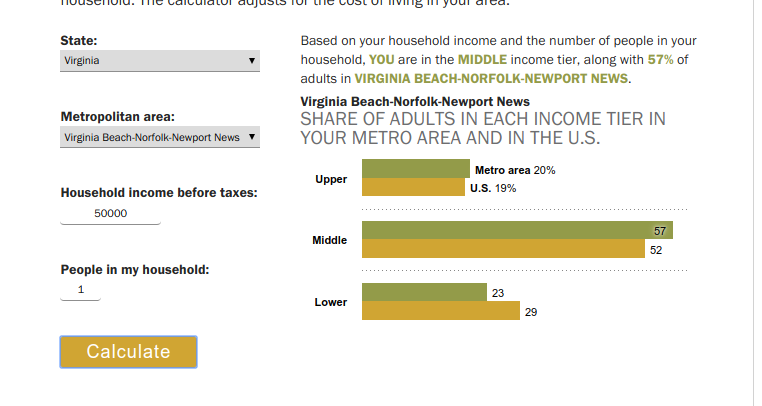

A single person earning $50K/year is in good company in the Virginia Beach, VA  middle class.

Data extracted from the 1990 US Census bureau database ( http://www.census.gov/ftp/pub/DES/www/welcome.html) 
by Ronny Kohavi and Barry Becker of Data Mining and Visualization Silicon Graphics (ronnyk@sgi.com for questions) provides insight to the question.

# Data

The 1994 US Census Data has been published with 15 fields including annual income above or below $50K. 

For the basis of this study these features have been used to determine which is most likely to predict incomes  above or below $50K:

age: a continuous variable that will be categorized into three groups, <30, 31-50, and over 70

workclass: 
                Private
                Self-emp-not-inc                Self-emp-inc
                Federal-gov                     Local-gov        State-gov
                Without-pay                     Never-worked

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  This field is deleted in deference to education-num

education-num: a continuous variable that is categorized into three levels: < high school degree, less than college degree and post-graduate.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black

sex: Female, Male

hours-per-week: a continuous variable categorized as less than 50 hours/week or more than

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.  This field was experimentally deleted to see what impact its wide range of data would have.  It made no difference to the final outcome

## Data Preparation



In [1]:
"""created on Thu Mar 28 15:12:14 2019
@author: jack sonntag

Analyze US Census data to predict the primary factor contributing to the 
population's subjects having an annual income of less then $50k.
"""

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import ensemble
from sklearn.svm import SVC

import time

import warnings
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning) #turn off compilier/library warning messages
warnings.simplefilter(action='ignore', category=Warning)

plt.rcParams["figure.figsize"] = [10,8 ] # enlarge plot size

In [2]:
#define three utility  functions

def list_columns(obj, cols, columnwise, gap):
    """
    Print the given list in evenly-spaced columns.
    INPUT:  
        obj :  The list to be printed.
        cols : The number of columns in which the list should be printed.
        columnwise : bool, default=True
        gap : The number of spaces that should separate the longest column
    OUTPUT:  printed list
    """

    sobj = [str(item) for item in obj]
    if cols > len(sobj): cols = len(sobj)
    max_len = max([len(item) for item in sobj])
    if columnwise: cols = int(math.ceil(float(len(sobj)) / float(cols)))
    plist = [sobj[i: i+cols] for i in range(0, len(sobj), cols)]
    if columnwise:
        if not len(plist[-1]) == cols:
            plist[-1].extend(['']*(len(sobj) - len(plist[-1])))
        plist = zip(*plist)
    printer = '\n'.join([
        ''.join([c.ljust(max_len + gap) for c in p])
        for p in plist])
    print (printer)
    
def show_results(total, wrong, model):
    """ provide a formatted comment output for the model accuracy data
    INPUT:  total: total data count
            wrong: count of incorrect predictions
            model:  label of the processing model
    OUTPUT: print statement
    """
    print ('{:14s}: {:5d} / {:5d} {:7.3f}%'.format(model, total-wrong, \
             total, round(100*(total-wrong)/total,4)))
    
def graph_feature_importance(clf,df): 
    """ produce the graph of feature importance
        INPUT: gradient booster classifer & dataframe to get Y axis labels
        OUTPUT: plot of feature importance
    """
    feature_importance = clf.feature_importances_[0:7] #use the top 7
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    print("sorted index of top values:",sorted_idx)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')


Open the data file.  This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html

'fnlwgt' - a continuous variable discarded because it was an internally derived weight factor which is not documented.

'closs' - a continues feature that tracks capital loss, was discarded because of the randomness of it's impact on annual income. 

'cg' - a continues feature that tracks capital gain, was discarded because of the randomness of it's impact on annual income. 

'educ' - was deleted in deference to using the 'edyrs' item.

'natcntry' - contained 42 different values, the inclusion of which did not affect the outcome.

In [3]:
filename = 'US Census Data.csv'
#filename = 'poverty_data.csv'
drop_list = ['fnlwgt','closs','cg','educ','natcntry'] #columns to drop
df = pd.read_csv(filename).dropna()
print (df.head())

   age          workclass  fnlwgt           educ  edyrs                mstat  \
0   38            Private   22245        Masters     14   Married-civ-spouse   
1   41            Private  443508      Bachelors     13   Married-civ-spouse   
2   46            Private  377401        HS-grad      9   Married-civ-spouse   
3   52            Private  145409   Some-college     10   Married-civ-spouse   
4   37   Self-emp-not-inc  258037        HS-grad      9   Married-civ-spouse   

                role   famstat    race    sex  closs    cg  hrs natcntry  \
0   Transport-moving   Husband   White   Male      0     0   72        ?   
1   Transport-moving   Husband   White   Male      0     0   48   Canada   
2   Transport-moving   Husband   White   Male      0  1902   70   Canada   
3   Transport-moving   Husband   White   Male  15024     0   60   Canada   
4   Transport-moving   Husband   White   Male      0     0   45     Cuba   

  income  
0   >50K  
1   >50K  
2   >50K  
3   >50K  
4   >50

Convert the continuous feature of age into three categories.

In [4]:
bins = [30,50,70]
names = ['young','mid','senior']
d = dict(enumerate(names, 1))
df['agerange'] = np.vectorize(d.get)(np.digitize(df['age'], bins))
drop_list.append('age')

Use 'income' as the outcome.  In the data it is either <50K or >50K, as a string variable.  Convert it to a 1 to represent income below $50K.

In [5]:
df['poverty'] = np.where(df['income'] == ' >50K',0,1) #set proverty to True for <50K
drop_list.append('income')  #drop the orignal column

'hrs' data is a continuous variable.  Redefine it as 'ambitious' (1) or not at a cut-off of 50 hours worked per week.

In [6]:
df['ambitious']= np.where(df['hrs'] >50, 1,0) # determine value of hours worked
drop_list.append('hrs')

'edyrs' contains a wide variety of years of education.  Convert it into three features.

In [7]:
#exchange numbers of education years into 3 categories - none, some & post college
bins = [8,12,16]
names = ['no_ed','some_ed','post_ed']
d = dict(enumerate(names, 1))
df['edrange'] = np.vectorize(d.get)(np.digitize(df['edyrs'], bins))
drop_list.append('edyrs')

Drop the designated columns accumulated in drop_list.  Then convert all categorical values into their own features.

In [8]:
df.drop(columns=drop_list,inplace=True)  #drop the list of columns 

col_list = df.columns.tolist()
df = pd.get_dummies(df,columns=col_list,drop_first=True)#convert all categorical values into their own features.
col_list = df.columns.tolist()
list_columns(col_list,3, True, 4 )#data, three colums, columns-wise, gap of 4


workclass_ Federal-gov          role_ Craft-repair              famstat_ Wife                   
workclass_ Local-gov            role_ Exec-managerial           race_ Asian-Pac-Islander        
workclass_ Never-worked         role_ Farming-fishing           race_ Black                     
workclass_ Private              role_ Handlers-cleaners         race_ Other                     
workclass_ Self-emp-inc         role_ Machine-op-inspct         race_ White                     
workclass_ Self-emp-not-inc     role_ Other-service             sex_ Male                       
workclass_ State-gov            role_ Priv-house-serv           agerange_mid                    
workclass_ Without-pay          role_ Prof-specialty            agerange_senior                 
mstat_ Married-AF-spouse        role_ Protective-serv           agerange_young                  
mstat_ Married-civ-spouse       role_ Sales                     poverty_1                       
mstat_ Married-spouse-absent  

Set y (income below $50K) as the outcome.  Set x as the rest of the features, remove the y.

In [9]:
y=df['poverty_1']  #outcome data
x=df # features
x.drop(columns='poverty_1',inplace=True) # remove outcome from features

The choose_focus_model() determines the prediction accuracy of 5 different models using default values: Random Forrest, multinomial, gaussaianNB, bernoulliNB & GradientBoostingClassifier.

In [10]:
def choose_focus_model(x,y):
    """ use 6 models at default processing to determine best model for in-depth
        processing
        INPUT:  x - features data
                y - outcome data
        OUTPUT: accuracy of each model
    
    """
    
    # create training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=0) 
    print("data set sizes:",len(X_train),len(X_test),len(Y_train),len(Y_test))
    
    model="Random Forest"
    #print(model)
    rfc = ensemble.RandomForestClassifier()
    rfc.fit(X_train, Y_train)
    y_pred = rfc.predict(X_test)# Classify, storing the result in a new variable.
    show_results(X_test.shape[0], (Y_test!= y_pred).sum(), model)
    
    model='multinomial'
    #print(model)
    bnb = MultinomialNB()
    bnb.fit(X_train,Y_train)
    y_pred = bnb.predict(X_test)# Classify, storing the result in a new variable.
    show_results(X_test.shape[0], (Y_test!= y_pred).sum(), model)
    
    model='gaussianNB '
    #print(model)
    bnb = GaussianNB()
    bnb.fit(X_train,Y_train)
    y_pred = bnb.predict(X_test)# Classify, storing the result in a new variable.
    show_results(X_test.shape[0], (Y_test != y_pred).sum(), model)

    model='BernoulliNB'
    #print(model)
    bnb = BernoulliNB()
    bnb.fit(X_train,Y_train)
    y_pred = bnb.predict(X_test)# Classify, storing the result in a new variable.
    show_results(X_test.shape[0], (Y_test != y_pred).sum(), model)

    model="Gradient   "
    #print(model)
    clf = ensemble.GradientBoostingClassifier()
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)# Classify, storing the result in a new variable.
    show_results(X_test.shape[0], (Y_test != y_pred).sum(), model)

# Graph importances relative to max importance.
    graph_feature_importance(clf, df)

Based on the above results, the GradientBoostingClassifier() will be used with varying parameters to improve the model's accuracy.

In [11]:
def tune_best_model(x,y):
    """ determine which parameters produce the most accurate model from the GradientBoostingClassifier()
        by looping through the 18 permutations of loss method, estimators and depth
        INPUT:  x - features data
                y - outcome data
        OUTPUT: graph of variable importance
    """

    model="Gradient"
    X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=0) 
    
    # depth = [2,4,8]# debgging shortcut
    #estimators = [5,10,20]# debgging shortcut
    
    estimators = [500,1000,2000]
    depth = [2,4,8]
    loss_type  = ['deviance', 'exponential']
    best_data_cols = ["LOSS   ", "   ESTIMATORS","DEPTH","ACCURACY "]
    data_tbl = pd.DataFrame(columns = best_data_cols)# store output to later choose best
    for lt in loss_type:     
        for est in estimators:
            for dep in depth:
               # print ("drilling down", lt,dep,est)
                params = {'n_estimators': est,'max_depth': dep, 'loss': lt}
                clf = ensemble.GradientBoostingClassifier(**params)
                
                clf.fit(X_train,Y_train)
                y_pred = clf.predict(X_test)
                label  = model + ": loss_type:" + lt + " estimator:" +  str(est) + " depth:" +str(dep)
                show_results(X_test.shape[0], (Y_test != y_pred).sum(), label)
                pct = (X_test.shape[0]-(Y_test != y_pred).sum())/X_test.shape[0]
                data_tbl = data_tbl.append(pd.Series([lt,est,dep,pct], \
                                           index=data_tbl.columns ), \
                                           ignore_index=True)
    data_tbl = data_tbl.sort_values(best_data_cols[3],ascending=False) # sort on accuracy
    print("best accuracy:\n",data_tbl.head(5))
    loss = data_tbl.iat[0, 0] #save off for use as the best parameter
    est =  data_tbl.iat[0, 1] # save off for use as the best parameter
    depth = data_tbl.iat[0, 2] #save off for use as the best parameter
    
    #use the best parameter set from above
    params = {'n_estimators': est,'max_depth': depth, 'loss': loss}
    print("last started...",params)
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    show_results(X_test.shape[0], (Y_test != y_pred).sum(), model)
    pct = (X_test.shape[0]-(Y_test != y_pred).sum())/X_test.shape[0]
    print("best accuracy:",round(pct*100,3),"%")
    graph_feature_importance(clf,X_train)


Start: 1555078031.09
data set sizes: 26048 6513 26048 6513
Random Forest :  5408 /  6513  83.034%
multinomial   :  5317 /  6513  81.637%
gaussianNB    :  3861 /  6513  59.281%
BernoulliNB   :  5132 /  6513  78.796%
Gradient      :  5474 /  6513  84.047%
sorted index of top values: [2 6 3 5 1 0 4]


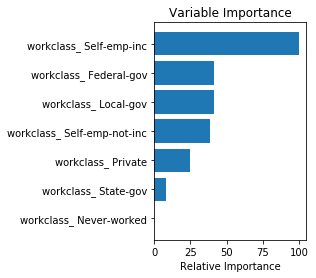

In [12]:
start_time = time.time()
print('Start: {:5.2f}'.format(start_time))
choose_focus_model(x,y)


The gradient boost classifer returns the best accuracy with default parameters, and indicates the relative importance of the features. 

Gradient: loss_type:deviance estimator:500 depth:2:  5486 /  6513  84.231%
Gradient: loss_type:deviance estimator:500 depth:4:  5484 /  6513  84.201%
Gradient: loss_type:deviance estimator:500 depth:8:  5414 /  6513  83.126%
Gradient: loss_type:deviance estimator:1000 depth:2:  5480 /  6513  84.139%
Gradient: loss_type:deviance estimator:1000 depth:4:  5474 /  6513  84.047%
Gradient: loss_type:deviance estimator:1000 depth:8:  5407 /  6513  83.019%
Gradient: loss_type:deviance estimator:2000 depth:2:  5483 /  6513  84.186%
Gradient: loss_type:deviance estimator:2000 depth:4:  5454 /  6513  83.740%
Gradient: loss_type:deviance estimator:2000 depth:8:  5399 /  6513  82.896%
Gradient: loss_type:exponential estimator:500 depth:2:  5480 /  6513  84.139%
Gradient: loss_type:exponential estimator:500 depth:4:  5473 /  6513  84.032%
Gradient: loss_type:exponential estimator:500 depth:8:  5421 /  6513  83.234%
Gradient: loss_type:exponential estimator:1000 depth:2:  5479 /  6513  84.124%
Gradie

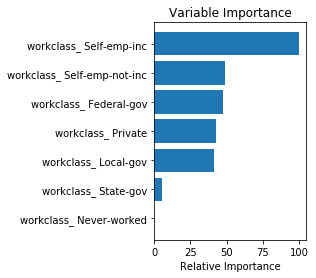

In [13]:
tune_best_model(x,y)
print('end mins: ',round(((time.time() - start_time)/60)))

The model parameters, (loss method - deviance, Estimators -2000, Depth - 8) which provide the best accuracy are plugged back in to run against the data.  The ranking of the top ten features is mostly unchanged.

# Conclusions

The model predicts with 84% accuracy that the clearest predictor of annual income level below $50K is working as an un-incorporated self employee.

In an attempt to ascertain whether 'self-emp-not-inc' (self employed not incorporated) might include part-time people who earn income from a hobby, the 'hrs' (hours) feature was removed with no impact on the variable importance.

Since the two highest predictors of limited income are flavors of self-employment, individuals who are considering that role need to be aware of the risk.

Three of the top six factors limiting income are government employment.